In [1]:
%reload_ext autoreload
%autoreload 2

In [3]:
import particle_builder as pb
import sam3d as s3d
import open3d as o3d
from psdframe import Frame
from psdstaticdataset import StaticDataset
from pathlib import Path
from matplotlib import pyplot as plt
from segment_anything import build_sam, SamAutomaticMaskGenerator
from util import Voxelize, num_to_natural


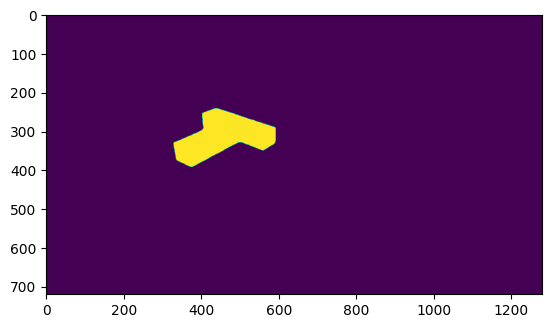

In [4]:
DS_PATH = Path("/home/david/projects/embodied_gaussians/datasets/simulated/single_1/modelling/static")
d = StaticDataset(DS_PATH / "transforms.json")
frames = d.frames
plt.imshow(frames[1].instance.cpu().numpy())
plt.show()

In [5]:
mask_generator = SamAutomaticMaskGenerator(build_sam(checkpoint=pb.sam_checkpoint).to(device="cuda"))
voxelize = Voxelize(voxel_size=pb.VOXEL_SIZE, mode="train", keys=("coord", "color", "group", "normals"))
intermediate_outputs_path = Path("/home/david/projects/SegmentAnything3D/outputs/notebook")

In [6]:
pcd_dict = pb.seg_pcd(d, mask_generator, voxelize, intermediate_outputs_path)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pcd_dict['coord'])
pcd.colors = o3d.utility.Vector3dVector(pcd_dict['color'])
o3d.visualization.draw_geometries([pcd])


merging 6 point clouds


/home/david/projects/SegmentAnything3D/.venv/lib/python3.10/site-packages/pointops/query.py:19: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:78.)
  idx = torch.cuda.IntTensor(m, nsample).zero_()


merging 3 point clouds
merging 2 point clouds


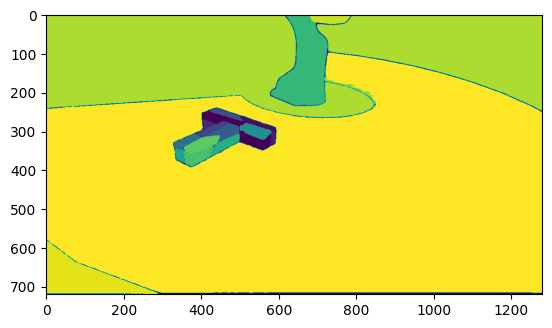

In [123]:
from PIL import Image
import numpy as np
img = Image.open("/home/david/projects/SegmentAnything3D/outputs/notebook/segments/side.png")
group_ids = np.array(img, dtype=np.int16)
plt.imshow(group_ids)
plt.show()

In [124]:
import logging
ch = logging.StreamHandler()
pb.logger.setLevel(logging.DEBUG)
pb.logger.addHandler(ch)

In [79]:
pb.initialize_scene(d, None, intermediate_outputs_path)


/home/david/projects/SegmentAnything3D/.venv/lib/python3.10/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch

OutOfMemoryError: CUDA out of memory. Tried to allocate 1024.00 MiB. GPU 0 has a total capacity of 9.77 GiB of which 576.38 MiB is free. Including non-PyTorch memory, this process has 8.51 GiB memory in use. Of the allocated memory 7.12 GiB is allocated by PyTorch, and 1.13 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [7]:
pb.extract_object_and_table_groups(pcd_dict, d)

([0, 2, 3, 4], 1)

In [8]:
pcd = o3d.geometry.PointCloud()
mask = pcd_dict['group'] == 0
pcd.points = o3d.utility.Vector3dVector(pcd_dict['coord'][mask] )
pcd.colors = o3d.utility.Vector3dVector(pcd_dict['color'][mask])
pcd.normals = o3d.utility.Vector3dVector(pcd_dict['normals'][mask])
#o3d.visualization.draw_geometries([pcd])
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(pcd, 0.03)
#mesh.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)

KeyboardInterrupt: 

In [157]:
(pcd_dict['coord'].shape,
pcd_dict['color'].shape,
pcd_dict['normals'].shape)


((237029, 3), (237029, 3), (237029, 3))

In [168]:
# find nan normals
mask = np.isnan(pcd_dict['color'])
pcd_dict['color'][mask]


array([], dtype=float64)

In [163]:
pcd_dict['normals'][231]

array([-3.54463351e-04,  9.62840451e-04, -9.99999464e-01])

In [169]:
radii = [0.005, 0.01, 0.02]
pcd = o3d.geometry.PointCloud()
#mask = (pcd_dict['group'] == 0)
pcd.points = o3d.utility.Vector3dVector(pcd_dict['coord'] )
pcd.colors = o3d.utility.Vector3dVector(pcd_dict['color'])
pcd.normals = o3d.utility.Vector3dVector(pcd_dict['normals'])

pcd = pcd.normalize_normals()
#o3d.visualization.draw_geometries([pcd])
#

#mesh.compute_vertex_normals()
#pcd.estimate_normals()
mesh, density = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=9)
#mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
#    pcd, o3d.utility.DoubleVector(radii))
#mesh.compute_vertex_normals()

# Remove low-density vertices
#vertices_to_remove = density < np.quantile(density, 0.05)
#mesh.remove_vertices_by_mask(vertices_to_remove)


o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)
 

[WARNING] /root/Open3D/build/poisson/src/ext_poisson/PoissonRecon/Src/FEMTree.Initialize.inl (Line 193)
          Initialize
          Found bad data: 231


In [9]:
mesh = pb.construct_mesh(pcd_dict)
o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)

[WARNING] /root/Open3D/build/poisson/src/ext_poisson/PoissonRecon/Src/FEMTree.Initialize.inl (Line 193)
          Initialize
          Found bad data: 228


In [12]:
meshes = pb.get_object_meshes(pcd_dict, d)
o3d.visualization.draw_geometries(meshes, mesh_show_back_face=True)




[WARNING] /root/Open3D/build/poisson/src/ext_poisson/PoissonRecon/Src/FEMTree.Initialize.inl (Line 193)
          Initialize
          Found bad data: 228


[Open3D WARNING] The number of points is 0 when creating axis-aligned bounding box.


In [13]:
t_mesh = meshes[0]
voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(t_mesh, 0.007)
o3d.visualization.draw_geometries([voxel_grid])

In [14]:
particles = pb.fill_mesh_with_particles(t_mesh)
#particles = pb.match_mesh_with_particles(t_mesh)

Dims: [15 15  3]


In [16]:
# for each particle instantiate a sphere at that location
spheres = []
for p in particles:
    sphere = o3d.geometry.TriangleMesh.create_sphere(radius=p.radius)
    sphere.paint_uniform_color([1, 0, 0])
    sphere.translate(p.xyz)
    spheres.append(sphere)
o3d.visualization.draw_geometries(spheres + [t_mesh], mesh_show_back_face=True)

In [190]:
o3d.visualization.draw_geometries([meshes[0]], mesh_show_back_face=True)

In [173]:
import pymeshfix

In [174]:
v = np.array(obj_mesh.vertices)
t = np.array(obj_mesh.triangles)
v.shape, t.shape

((3843, 3), (7419, 3))

In [180]:
v = np.array(obj_mesh.vertices)
t = np.array(obj_mesh.triangles)
nv, nt = pymeshfix.clean_from_arrays(v,t, verbose=True)
clean_obj_mesh = o3d.geometry.TriangleMesh()
clean_obj_mesh.vertices = o3d.utility.Vector3dVector(nv)
clean_obj_mesh.triangles = o3d.utility.Vector3iVector(nt)
o3d.visualization.draw_geometries([clean_obj_mesh], mesh_show_back_face=True)



INFO- Loaded 110556 vertices and 218620 faces.
Patching holes...
Patched 21 holes
Fixing degeneracies and intersections

100% done 
INFO- ********* ITERATION 0 *********
INFO- Removing degeneracies...
INFO- Removing self-intersections...

99 % done   
INFO- 20482 intersecting triangles have been selected.

99 % done   
INFO- 6388 intersecting triangles have been selected.

99 % done   
INFO- 1038 intersecting triangles have been selected.
INFO- ********* ITERATION 1 *********
INFO- Removing degeneracies...
INFO- Removing self-intersections...

99 % done   ne   
INFO- 366 intersecting triangles have been selected.

99 % done   
INFO- 258 intersecting triangles have been selected.

99 % done   
INFO- 159 intersecting triangles have been selected.
INFO- ********* ITERATION 2 *********
INFO- Removing degeneracies...
INFO- Removing self-intersections...

99 % done   
INFO- 375 intersecting triangles have been selected.

99 % done   done   
INFO- 77 intersecting triangles have been selected.

In [135]:
voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(clean_obj_mesh, 0.007)
o3d.visualization.draw_geometries([voxel_grid])



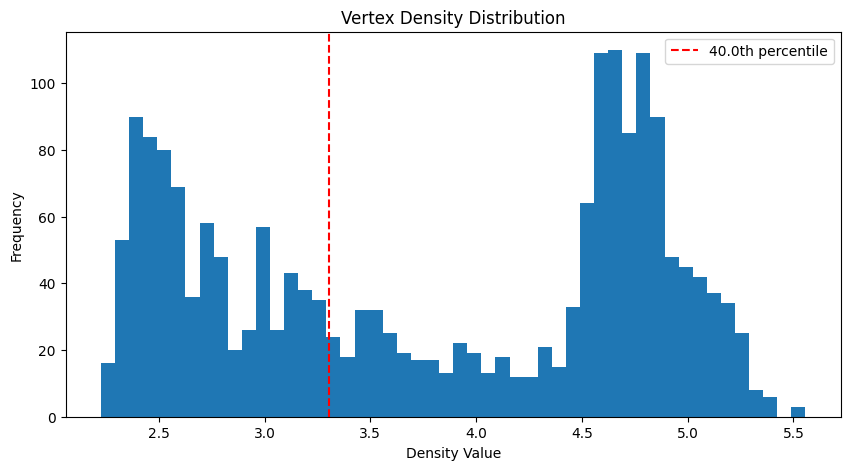

In [34]:
# Plot density histogram
plt.figure(figsize=(10, 5))
plt.hist(density, bins=50)
plt.xlabel('Density Value')
plt.ylabel('Frequency')
plt.title('Vertex Density Distribution')

# Add vertical line for threshold
threshold = np.quantile(density, 0.4)
plt.axvline(x=threshold, color='r', linestyle='--', 
            label=f'{0.4*100}th percentile')
plt.legend()
plt.show()

In [11]:
o3d.visualization.draw_geometries([pcd], point_show_normal=True)

In [77]:
pcd2_dict = pb.get_pcd(d.frames[0], mask_generator, intermediate_outputs_path)


Downloading/Locating SAM checkpoint...
Sam checkpoint in located at /home/david/.frame-seg-init/models/sam_vith.pth
/home/david/projects/SegmentAnything3D/particle_builder.py:125: RuntimeWarning: invalid value encountered in cast
  return save_dict


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0000001..0.99999046].


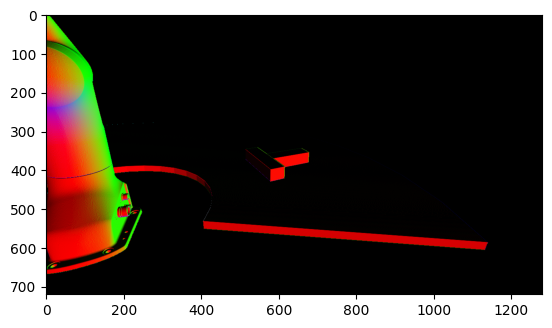

In [76]:
frame = d.frames[0] 
normals = pb.normals_from_depth(frame.depth, frame.K)

normals = normals.view(-1, 3) @ frame.X_WV_opencv[:3, :3].cuda().T
normals = normals.reshape(frame.color.shape)

plt.imshow(normals.cpu().numpy())
plt.show()


In [70]:
normals.shape

torch.Size([921600, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.999998].


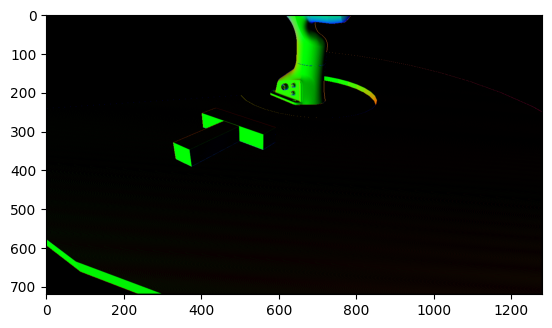

In [73]:
frame = d.frames[1] 
normals = pb.normals_from_depth(frame.depth, frame.K)

normals = (frame.X_WV_opencv[:3, :3].cuda() @ normals.view(-1, 3).cuda().T).T
normals = normals.reshape(frame.color.shape)

plt.imshow(normals.cpu().numpy())
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99999994..0.9999753].


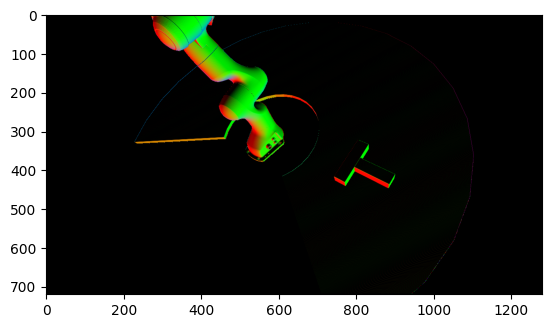

In [74]:
frame = d.frames[3] 
normals = pb.normals_from_depth(frame.depth, frame.K)

normals = (frame.X_WV_opencv[:3, :3].cuda() @ normals.view(-1, 3).cuda().T).T
normals = normals.reshape(frame.color.shape)

plt.imshow(normals.cpu().numpy())
plt.show()

In [78]:
pcd2 = o3d.geometry.PointCloud()
pcd3_dict = pcd2_dict
#pcd3_dict = voxelize(pcd2_dict)

pcd2.points = o3d.utility.Vector3dVector(pcd3_dict['coord'][::100])
pcd2.colors = o3d.utility.Vector3dVector(pcd3_dict['color'][::100])
pcd2.normals = o3d.utility.Vector3dVector(pcd3_dict['normals'][::100])
#pcd3 = pcd2.uniform_down_sample(every_k_points=10)
#pcd4 = pcd3.normalize_normals()
o3d.visualization.draw_geometries([pcd2], point_show_normal=True)

In [54]:
pcd2_dict['coord'].shape

(921600, 3)

In [55]:
pcd2_dict['color'].shape

(921600, 3)

In [56]:
pcd2_dict['normals'].shape

(921600, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


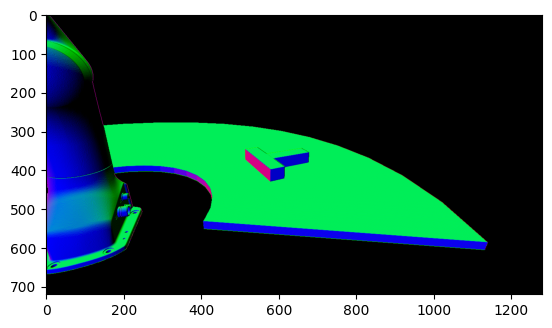

In [59]:
plt.imshow(pcd2_dict['normals'].reshape(frame.color.shape))
plt.show()

In [57]:
pcd2_dict['group'].shape

(921600,)

In [44]:
frame.depth[frame.depth > 0].shape


torch.Size([280653])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


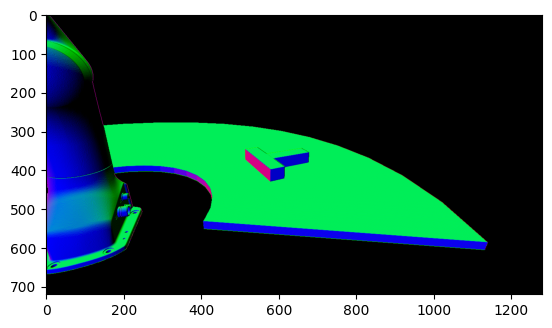

In [26]:
plt.imshow(np.array(pcd2.normals).reshape(frame.color.shape))
plt.show()

In [42]:
np.array(pcd3.normals)

array([], shape=(0, 3), dtype=float64)

In [33]:
pcd2_dict['normals']

array([[-0.98713738,  0.10990769, -0.11610405],
       [-0.97471774,  0.09768923, -0.2009531 ],
       [-0.96052033,  0.17513835, -0.2161648 ],
       ...,
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]])

In [40]:
np.array(pcd2.normals)


array([[-0.98713738,  0.10990769, -0.11610405],
       [-0.97471774,  0.09768923, -0.2009531 ],
       [-0.96052033,  0.17513835, -0.2161648 ],
       ...,
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]])